# Second approach

In [ ]:
!python -m pip install json-lines

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import defaultdict
from typing import Callable
import torch.nn as nn
import numpy as np
import collections
import torch
import json_lines
import os
import re

from tqdm.auto import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Building dictionaries and datasets

In [ ]:
path_to_train_data = '/content/drive/MyDrive/NLP/Homework1/data/train.jsonl'
path_to_val_data = '/content/drive/MyDrive/NLP/Homework1/data/dev.jsonl'

In [ ]:
# Load previously built dictionaries with the pretrained embedding for each word
glove_dict = np.load('/content/drive/MyDrive/NLP/Homework1/glove_dictionary.npy', allow_pickle='TRUE').item()
word2vec_dict = np.load('/content/drive/MyDrive/NLP/Homework1/word2vec_dictionary.npy', allow_pickle='TRUE').item()
dictionary = np.load('/content/drive/MyDrive/NLP/Homework1/glove_w2v_dictionary.npy', allow_pickle='TRUE').item()

In [ ]:
# This function is used to index all the words in the three dictionaries that we have
# just loaded. It returns the dictionary with the word and its index, that correspond
# to the position of its embedding in the word_vectors list

def build_idx_dictionary(dictionary: dict, mixed: bool):
  word_idxs = dict()
  word_vectors = []

  # reserve indexes 0 and 1 repsectively for the pad token and the unknown token
  if mixed:
    word_vectors.append(torch.rand(600))
    word_vectors.append(torch.rand(600))
  else:
    word_vectors.append(torch.rand(300))
    word_vectors.append(torch.rand(300))

  for word, vector in dictionary.items():
    word_idxs[word] = len(word_vectors)
    word_vectors.append(vector)

  word_idxs = defaultdict(lambda: 1, word_idxs)
  word_vectors = torch.stack(word_vectors)

  return word_idxs, word_vectors

In [ ]:
word_idxs_glove, word_vectors_glove = build_idx_dictionary(glove_dict, mixed=False)
word_idxs_w2v, word_vectors_w2v = build_idx_dictionary(word2vec_dict, mixed=False)
word_idxs_mixed, word_vectors_mixed = build_idx_dictionary(dictionary, mixed=True)

In [ ]:
# Preprocess each input sentence
def preprocess_sentence(sentence: str) -> str:

  sentence = sentence.lower()
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(sentence)

  tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords.words("english")]

  return sentence

In [ ]:
# Function to get the indices of all the words in input sentences
def sentence2idx(sentence1:str, sentence2:str, word_idxs: dict) -> torch.Tensor:
  sentence1 = torch.tensor([word_idxs[word] for word in word_tokenize(sentence1)], dtype=torch.long)
  sentence2 = torch.tensor([word_idxs[word] for word in word_tokenize(sentence2)], dtype=torch.long)
  return torch.cat((sentence1, sentence2), 0)

In [ ]:
def collate_function(input_data):
  x = [input[0] for input in input_data]

  x_len = torch.tensor([xi.size(0) for xi in x], dtype=torch.long)

  # we pad the list of index tensors to get shape (batch_size x max_seq_len)
  x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=0)

  y = [input[1] for input in input_data]
  y = torch.tensor(y)

  return x, x_len, y

In [ ]:
class WordInContextDataset(Dataset):
  
  def __init__(self, data_path : str, sentence2idx, word_idxs: dict):
    self.data = []
    self.create_samples(data_path, sentence2idx, word_idxs)

  def create_samples(self, data_path, sentence2idx, word_idxs):

    with open(data_path) as f:
      for line in json_lines.reader(f):
        sentence1 = preprocess_sentence(line['sentence1'])
        sentence2 = preprocess_sentence(line['sentence2'])
        
        sentence_vector = sentence2idx(sentence1, sentence2, word_idxs=word_idxs).to(device)

        if sentence_vector is None:
          continue

        label = line['label']
        if label == 'True':
          label = 1
        else:
          label = 0
        
        self.data.append((sentence_vector, label))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
train_dataset_glove = WordInContextDataset(path_to_train_data, sentence2idx, word_idxs=word_idxs_glove)
val_dataset_glove = WordInContextDataset(path_to_val_data, sentence2idx, word_idxs=word_idxs_glove)

train_dataloader_glove = DataLoader(train_dataset_glove, batch_size=32, collate_fn=collate_function)
val_dataloader_glove = DataLoader(val_dataset_glove, batch_size=32, collate_fn=collate_function)

In [ ]:
train_dataset_w2v = WordInContextDataset(path_to_train_data, sentence2idx, word_idxs_w2v)
val_dataset_w2v = WordInContextDataset(path_to_val_data, sentence2idx, word_idxs_w2v)

train_dataloader_w2v = DataLoader(train_dataset_w2v, batch_size=32, collate_fn=collate_function)
val_dataloader_w2v = DataLoader(val_dataset_w2v, batch_size=32, collate_fn=collate_function)

In [ ]:
train_dataset_mixed = WordInContextDataset(path_to_train_data, sentence2idx, word_idxs_mixed)
val_dataset_mixed = WordInContextDataset(path_to_val_data, sentence2idx, word_idxs_mixed)

train_dataloader_mixed = DataLoader(train_dataset_mixed, batch_size=32, collate_fn=collate_function)
val_dataloader_mixed = DataLoader(val_dataset_mixed, batch_size=32, collate_fn=collate_function)

## Build the classifier

In [ ]:
class Classifier(nn.Module):
  def __init__(self, word_vectors, hidden_size, output_classes):
    super().__init__()
    self.global_epoch = 0

    self.embedding = torch.nn.Embedding.from_pretrained(word_vectors, padding_idx=0)
    self.rnn = torch.nn.LSTM(input_size=word_vectors.size(1), hidden_size=hidden_size,
                             bidirectional=True, num_layers=1, batch_first=True, dropout=0.0)
    
    self.lin1 = nn.Linear(hidden_size*2, hidden_size)
    self.lin2 = nn.Linear(hidden_size, output_classes)

    self.dropout = nn.Dropout(0.2)

    self.loss_fn = nn.BCELoss()

  def forward(self, x, x_len, y=None):
    output_embedding = self.embedding(x)
    output_embedding = self.dropout(output_embedding)
    output_rnn = self.rnn(output_embedding)[0]

    batch_size, seq_length, hidden_size = output_rnn.shape

    output_flat = output_rnn.reshape(-1, hidden_size)

    last_word_relative_idxs = x_len - 1
    sequences_offsets = torch.arange(batch_size) * seq_length
    summary_vectors_indices = last_word_relative_idxs + sequences_offsets

    representative_vectors = output_flat[summary_vectors_indices.long()]

    out = self.lin1(representative_vectors)
    out = torch.relu(out)
    out = self.dropout(out)
    out = self.lin2(out).squeeze(1)
    out = torch.sigmoid(out)

    result = {'pred': out}

    if y is not None:
      loss = self.loss(out, y.float())
      result['loss'] = loss

    return result
  
  def loss(self, pred, y):
    return self.loss_fn(pred, y.to(device))

In [ ]:
def evaluate_model(model: nn.Module, dataloader: DataLoader):
  losses = []
  predictions = []
  labels = []
  n = 0
  d = 0

  for batch in dataloader:
    x, x_len, y = batch
    y = y.to(device)
    outputs = model(x, x_len, y)
    loss = outputs['loss']
    losses.append(loss)
    pred = outputs['pred']
    pred = torch.round(pred)
    predictions.append(pred)
    labels.append(y)
    
    d += pred.shape[0]
    n += (y == pred).int().sum()

  mean_loss = sum(losses) / len(losses)
  return {'loss': mean_loss, 'accuracy': (n / d).item()}

In [ ]:
def train_and_evaluate(model: nn.Module, optimizer: torch.optim.Optimizer, 
                       train_dataloader: DataLoader, epochs: int = 5,
                       valid_dataloader: DataLoader = None, valid_fn: Callable = None,
                       verbose: bool = True):
  train_acc = []
  train_loss = []
  val_acc = []
  val_loss = []
  n = 0
  d = 0

  min_val_loss = np.Inf 
  stop_epochs = 5
  no_improvement = 0

  for epoch in range(epochs):
    losses = []
    predictions = []
    labels = []

    # batches of the training set
    for batch in train_dataloader:
      x, x_len, y = batch
      y = y.to(device)
      optimizer.zero_grad()
      batch_out = model(x, x_len, y)
      loss = batch_out['loss']
      losses.append(loss)
      pred = batch_out['pred']
      pred = torch.round(pred)
      predictions.append(pred)
      labels.append(y)

      # computes the gradient of the loss
      loss.backward()
      # updates parameters based on the gradient information
      optimizer.step()

      d += pred.shape[0]
      n += (y == pred).int().sum()

    model.global_epoch += 1
    mean_loss = sum(losses) / len(losses)
    accuracy = (n / d).item();

    train_loss.append(mean_loss.item())
    train_acc.append(accuracy)
    if verbose or epoch == epochs - 1:
      print(f' Epoch {model.global_epoch:3d} => Loss: {mean_loss:0.6f}, Accuracy: {accuracy:0.2f}')
    
    if verbose and valid_dataloader:
      assert valid_fn is not None
      valid_output = valid_fn(model, valid_dataloader)
      valid_loss = valid_output['loss']
      valid_accuracy = valid_output['accuracy']
      val_loss.append(valid_loss.item())
      val_acc.append(valid_accuracy)
      print(f' Validation => Loss: {valid_loss:0.6f}, Accuracy: {valid_accuracy:0.2f}')
      print()

    if valid_loss <= min_val_loss:
      no_improvement = 0
      min_val_loss = valid_loss
    else:
      no_improvement += 1

    if no_improvement == stop_epochs:
      print('Early stopping!')
      break
    else:
      continue

  return {'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss': val_loss}

### Training using GloVe word embeddings



In [ ]:
glove_model = Classifier(word_vectors=word_vectors_glove, hidden_size=128, output_classes=1).to(device)
optimizer = torch.optim.Adam(glove_model.parameters(), lr=0.0001, betas=(0.85, 0.999)) 

glove_logs = train_and_evaluate(model=glove_model, optimizer=optimizer,
                          train_dataloader=train_dataloader_glove,
                          valid_dataloader=val_dataloader_glove,
                          valid_fn=evaluate_model,
                          epochs=100)

 Epoch   1 => Loss: 0.694477, Accuracy: 0.50
 Validation => Loss: 0.693042, Accuracy: 0.52

 Epoch   2 => Loss: 0.694192, Accuracy: 0.50
 Validation => Loss: 0.692574, Accuracy: 0.52

 Epoch   3 => Loss: 0.693779, Accuracy: 0.50
 Validation => Loss: 0.692970, Accuracy: 0.51

 Epoch   4 => Loss: 0.693136, Accuracy: 0.50
 Validation => Loss: 0.692542, Accuracy: 0.52

 Epoch   5 => Loss: 0.692838, Accuracy: 0.51
 Validation => Loss: 0.692085, Accuracy: 0.53

 Epoch   6 => Loss: 0.691454, Accuracy: 0.51
 Validation => Loss: 0.689392, Accuracy: 0.55

 Epoch   7 => Loss: 0.689866, Accuracy: 0.51
 Validation => Loss: 0.688070, Accuracy: 0.55

 Epoch   8 => Loss: 0.686451, Accuracy: 0.52
 Validation => Loss: 0.686459, Accuracy: 0.55

 Epoch   9 => Loss: 0.683183, Accuracy: 0.52
 Validation => Loss: 0.685809, Accuracy: 0.55

 Epoch  10 => Loss: 0.680719, Accuracy: 0.53
 Validation => Loss: 0.687368, Accuracy: 0.54

 Epoch  11 => Loss: 0.677769, Accuracy: 0.53
 Validation => Loss: 0.685285, Accu

In [ ]:
PATH = '/content/drive/MyDrive/NLP/Homework1/models/approach2_3.pth'
#torch.save(glove_model.state_dict(), PATH)

### Training using Word2Vec word embeddings

In [ ]:
w2v_model = Classifier(word_vectors=word_vectors_w2v, hidden_size=64, output_classes=1).to(device)
optimizer = torch.optim.Adam(w2v_model.parameters(), lr=0.0001, betas=(0.85, 0.999))

w2v_logs = train_and_evaluate(model=w2v_model, optimizer=optimizer,
                          train_dataloader=train_dataloader_w2v,
                          valid_dataloader=val_dataloader_w2v,
                          valid_fn=evaluate_model,
                          epochs=100)

 Epoch   1 => Loss: 0.694757, Accuracy: 0.50
 Validation => Loss: 0.692769, Accuracy: 0.54

 Epoch   2 => Loss: 0.694131, Accuracy: 0.50
 Validation => Loss: 0.693140, Accuracy: 0.50

 Epoch   3 => Loss: 0.694001, Accuracy: 0.49
 Validation => Loss: 0.693026, Accuracy: 0.51

 Epoch   4 => Loss: 0.693876, Accuracy: 0.49
 Validation => Loss: 0.693380, Accuracy: 0.47

 Epoch   5 => Loss: 0.693551, Accuracy: 0.49
 Validation => Loss: 0.693725, Accuracy: 0.45

 Epoch   6 => Loss: 0.693455, Accuracy: 0.50
 Validation => Loss: 0.693340, Accuracy: 0.49

Early stopping!


In [ ]:
#OUTPUT_PATH = '/content/drive/MyDrive/NLP/Homework1/models/pretrained_w2v.pth'
#torch.save(w2v_model.state_dict(), OUTPUT_PATH)

### Training using concatenated GloVe and Word2Vec word embeddings

In [ ]:
mixed_model = Classifier(word_vectors_mixed, hidden_size=64, output_classes=1).to(device)
optimizer = torch.optim.Adam(mixed_model.parameters(), lr=0.0001, betas=(0.85, 0.999))

mixed_logs = train_and_evaluate(model=mixed_model, optimizer=optimizer,
                          train_dataloader=train_dataloader_mixed,
                          valid_dataloader=val_dataloader_mixed,
                          valid_fn=evaluate_model,
                          epochs=100)

 Epoch   1 => Loss: 0.694962, Accuracy: 0.50
 Validation => Loss: 0.692923, Accuracy: 0.50

 Epoch   2 => Loss: 0.694060, Accuracy: 0.50
 Validation => Loss: 0.693334, Accuracy: 0.50

 Epoch   3 => Loss: 0.693847, Accuracy: 0.51
 Validation => Loss: 0.692581, Accuracy: 0.51

 Epoch   4 => Loss: 0.693227, Accuracy: 0.51
 Validation => Loss: 0.692527, Accuracy: 0.51

 Epoch   5 => Loss: 0.692116, Accuracy: 0.51
 Validation => Loss: 0.691600, Accuracy: 0.54

 Epoch   6 => Loss: 0.691204, Accuracy: 0.51
 Validation => Loss: 0.690920, Accuracy: 0.56

 Epoch   7 => Loss: 0.689598, Accuracy: 0.51
 Validation => Loss: 0.688607, Accuracy: 0.54

 Epoch   8 => Loss: 0.688034, Accuracy: 0.52
 Validation => Loss: 0.687612, Accuracy: 0.57

 Epoch   9 => Loss: 0.685838, Accuracy: 0.52
 Validation => Loss: 0.687150, Accuracy: 0.55

 Epoch  10 => Loss: 0.682730, Accuracy: 0.53
 Validation => Loss: 0.686870, Accuracy: 0.55

 Epoch  11 => Loss: 0.678430, Accuracy: 0.53
 Validation => Loss: 0.685526, Accu

In [ ]:
#OUTPUT_PATH = '/content/drive/MyDrive/NLP/Homework1/models/pretrained_mixed.pth'
#torch.save(mixed_model.state_dict(), OUTPUT_PATH)

## Evaluating the model

In [ ]:
def overall_validation_performance(model, val_dataloader):
  n = 0
  d = 0

  for batch in val_dataloader:
    x, x_len, y = batch
    y = y.to(device)
    with torch.no_grad():
      batch_out = model(x, x_len)
      pred = batch_out['pred']

    pred = torch.round(pred)
    d += pred.shape[0]
    n += (y == pred).int().sum()

  print(f'# accuracy: {(n / d).item():.2f}')

In [ ]:
def plot_metrics(logs):
  plt.figure(figsize=(15,3))
  plt.subplot(1, 2, 1)
  plt.plot(logs['train_acc'],'-')
  plt.plot(logs['val_acc'],'-')
  plt.xlabel('epoch', fontsize=14)
  plt.ylabel('accuracy', fontsize=14)
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Accuracy', fontsize=16)

  plt.subplot(1, 2, 2)
  plt.plot(logs['train_loss'],'-')
  plt.plot(logs['val_loss'],'-')
  plt.xlabel('epoch', fontsize=14)
  plt.ylabel('loss', fontsize=14)
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Loss', fontsize=16)

### Results with GloVe

In [ ]:
overall_validation_performance(glove_model, val_dataloader_glove)

# accuracy: 0.57


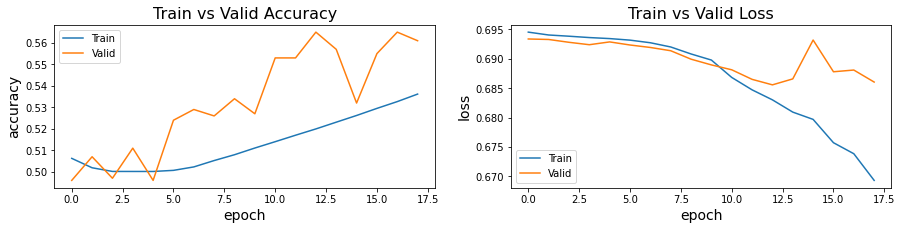

In [ ]:
plot_metrics(glove_logs)

### Results with Word2Vec

In [ ]:
overall_validation_performance(w2v_model, val_dataloader_w2v)

# accuracy: 0.53


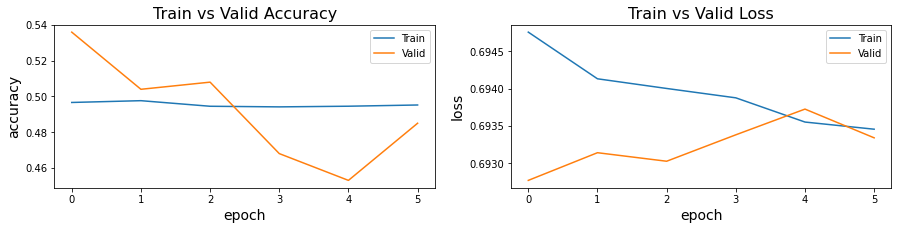

In [ ]:
plot_metrics(w2v_logs)

In [ ]:
overall_validation_performance(mixed_model, val_dataloader_mixed)

# accuracy: 0.56


### Results with concatenated GloVe and Word2Vec word embeddings

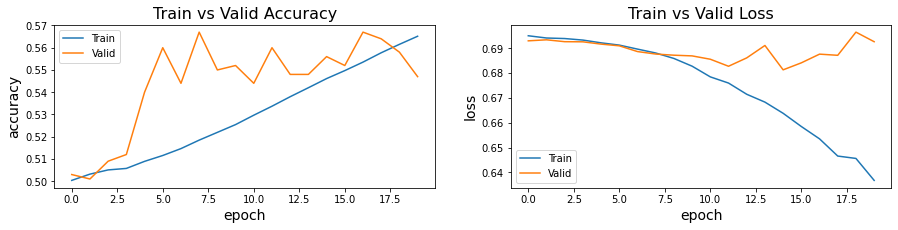

In [ ]:
plot_metrics(mixed_logs)